## Part 1 ‑ Exploratory data analysis

In [104]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
%matplotlib inline

In [2]:
with open('logins.json', 'r') as datafile:
    data = json.load(datafile)
df_login = pd.DataFrame(data)
df_login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
login_time = df_login.set_index('login_time')
login_time['Counting'] = pd.Series(1,index=login_time.index)
login_time.index = pd.to_datetime(login_time.index)
login_resample = login_time.resample('15T').count()
login_resample.head()

,Counting
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [4]:
login_weekday = login_time.resample('15T').count()
login_weekend = login_time.resample('15T').count()
for i in range(len(login_resample)):
    if login_weekday.index[i].weekday() > 5:
        login_weekday.ix[i,'Counting'] = 0
    if login_weekend.index[i].weekday() <= 5:
        login_weekend.ix[i,'Counting'] = 0

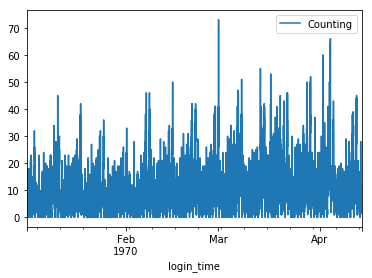

In [5]:
login_resample.plot()

In [6]:
login_resample['time'] = pd.Series(login_resample.index.time,index=login_resample.index)
login_weekday['time'] = pd.Series(login_weekday.index.time,index=login_resample.index)
login_weekend['time'] = pd.Series(login_weekend.index.time,index=login_resample.index)

new_login_resample = login_resample.reset_index().set_index('time')
new_login_weekday = login_weekday.reset_index().set_index('time')
new_login_weekend = login_weekend.reset_index().set_index('time')

new_login_resample = new_login_resample.drop('login_time',1)
new_login_weekday = new_login_weekday.drop('login_time',1)
new_login_weekend = new_login_weekend.drop('login_time',1)

new_login_resample.head()

,Counting
time,
20:00:00,2
20:15:00,6
20:30:00,9
20:45:00,7
21:00:00,1


In [7]:
dic = {}
dic_wd = {}
dic_we = {}
for i in range(len(new_login_resample)):
    dic[new_login_resample.index[i]] = dic.get(new_login_resample.index[i],0) + new_login_resample['Counting'][i]
    dic_wd[new_login_weekday.index[i]] = dic_wd.get(new_login_weekday.index[i],0) + new_login_weekday['Counting'][i]
    dic_we[new_login_weekend.index[i]] = dic_we.get(new_login_weekend.index[i],0) + new_login_weekend['Counting'][i]

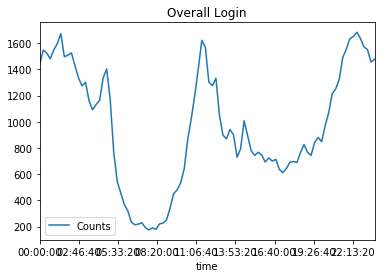

In [28]:
new_dt = pd.DataFrame.from_dict(dic,orient='index')
new_dt.columns = ['Counts']
total_login = new_dt['Counts'].sum()
new_dt.plot()
plt.title('Overall Login')

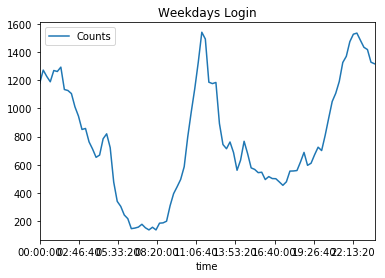

In [29]:
new_dt_wd = pd.DataFrame.from_dict(dic_wd,orient='index')
new_dt_wd.columns = ['Counts']
new_dt_wd.plot()
plt.title('Weekdays Login')

In [32]:
percent_wd = new_dt_wd['Counts'].sum() / total_login
percent_wd

0.8049537265680359

In [34]:
# Percentage of daily logins for weekdays
percent_wd/5

0.1609907453136072

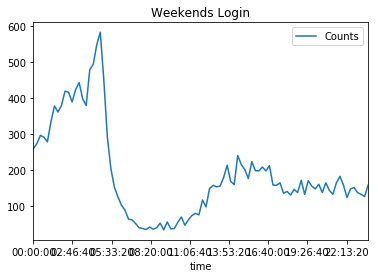

In [30]:
new_dt_we = pd.DataFrame.from_dict(dic_we,orient='index')
new_dt_we.columns = ['Counts']
new_dt_we.plot()
plt.title('Weekends Login')

In [33]:
percent_we = new_dt_we['Counts'].sum() / total_login
percent_we

0.1950462734319641

In [35]:
# Percentage of daily logins for weekends
percent_we/2

0.09752313671598205

<br>1. I first resampled all data into 15-minute time intervals, and ploted all data in a same figure. What I found is in general, there will be more numbers of login during weekdays than weekdends. So I think the demand is different between weekdays and weekends. But it's hard to tell the difference in this figure.<br/>
<br>2. Then I aggregated all login data into a daily interval, with three different catergories, which are weekdays, weekends, and overall. <br/>
<br>From the plot, we could notice that the weekdays login and overall login share a similar distribution (daily cycle): That is, from 9AM, there is large increses in number of login, and during 10AM to 12PM, it remains in high demand. From 12PM to 10PM, the demand is at the average level. And after 10PM, another peak of demand comes and it lasts until 1AM. Then the login number start decreasing. From 6AM to 9AM, there is few login during this time.<br/>
<br>From the weekends plot, we saw a different distribution of logins. The demand remains stable and relatively low during the day, from 12PM to 12AM. The demand increases from 12AM and the peak of demand is from 3AM to 5AM, which is much different from that of weekdays. And the demand drops and after 6AM, there is few login until 12PM.<br/>
<br>3. I checked the average logins of each catergory, and it shows that weekdays have much more logins per day than that of weekends, which means there are more demands during weekdays.<br/>

## Part 2 ‑ Experiment and metrics design

<br>1. I would choose the daily number of cars passes the toll as the key measure of success, including the number from Gotham to Metropolis and the number from Metropolis to Gotham. And this number gives an intuitive result whether the operations are successful, and we could say it is effective if the number increases.<br/>

<br>2. a. The experiment takes the daily data for two months, and one month for control group (no operation), one month for experimental group (with operations). So at the end of experiment, 30 samples will be available for both groups. Note that the days for experiment longer is better. If the sample size is less than 30, then this is a T-statistics.<br/>
<br>b. After the experiment, I supposed to get a Z-statistics, or a normal distribution for both groups. Then we will have two groups of data with mean and standard deviation. Then I can set up a hypothesis test for difference of means.<br/>
<br>c. I will set a null hypothesis that there is no change in the experiment, as well as an alternative hypothesis. And I will figure out if the null hypothesis is true with significant level of 5%. And if not, we could conclude that there is effectiveness of the proposed change.<br/>

## Part 3 ‑ Predictive modeling

In [12]:
with open('ultimate_data_challenge.json', 'r') as datafile:
    data_3 = json.load(datafile)
df = pd.DataFrame(data_3)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [65]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
last_day = df['last_trip_date'].max()
last_day_active = last_day - pd.Timedelta('30 days')
last_day_active

Timestamp('2014-06-01 00:00:00')

In [73]:
df['active'] = pd.Series(0,index=df.index)
df['ultimate'] = pd.Series(0,index=df.index)
for i in range(len(df)):
    if df['last_trip_date'][i] >= last_day_active:
        df.ix[i,'active'] = 1
    if df['ultimate_black_user'][i]:
        df.ix[i,'ultimate'] = 1

In [79]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,ultimate
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,0


#### Created a new column to indicate whether the users are still active, based on their last trip date is before June 1st or not. (1 for active, 0 for inactive). Also, modify the 'ultimate' column into boolean integer.

In [88]:
df_city = df[['city','active']]
df_city.groupby('city').mean()

,active
city,
Astapor,0.255715
King's Landing,0.628134
Winterfell,0.351945


In [90]:
df_phone = df[['phone','active']]
df_phone.groupby('phone').mean()

,active
phone,
Android,0.209426
iPhone,0.448933


#### I took the mean values of 'active' of different cities and phones. And these show that there are some intrinsic relationships between active and city (or phone).

In [76]:
df_data = df[['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct','ultimate','active']]
df_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,ultimate,active
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0


In [78]:
df_data.groupby('active').mean()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,ultimate
active,,,,,,,,
0,6.207939,4.787464,4.607557,1.075339,8.666739,1.658482,60.647032,0.299942
1,5.114788,4.762772,4.592930,1.073809,9.152797,3.306318,61.389034,0.505052


#### I also took the average values of all feature, which are grouped by 'active'. We could notice that there are some values are really close, so I would consider that feature won't affect the result too much. And I extracted the features with some differences and do analysis on them.

In [91]:
df_final = df_data[['avg_dist','trips_in_first_30_days','ultimate','active']]
df_final.head()

,avg_dist,trips_in_first_30_days,ultimate,active
0,3.67,4,1,1
1,8.26,0,0,0
2,0.77,3,0,0
3,2.36,9,1,1
4,3.13,14,0,0


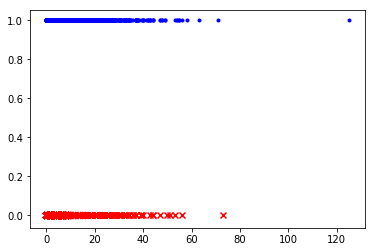

In [100]:
df_0 = df[df.active == 0]
df_1 = df[df.active == 1]
plt.scatter(df_0.trips_in_first_30_days, df_0.active,color = 'r',marker = 'x')
plt.scatter(df_1.trips_in_first_30_days, df_1.active,color = 'b',marker = '.')

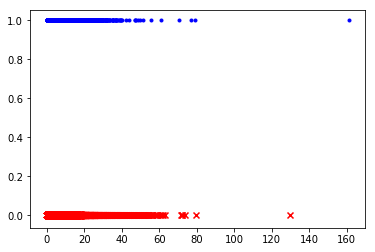

In [101]:
plt.scatter(df_0.avg_dist, df_0.active,color = 'r',marker = 'x')
plt.scatter(df_1.avg_dist, df_1.active,color = 'b',marker = '.')

In [106]:
np.corrcoef(df.active,df.ultimate)

array([[ 1.        ,  0.20500202],
       [ 0.20500202,  1.        ]])

#### I plotted the relationship between active and other features, and from the plot, I noticed that they are not linear relationships, and I cannot use a simple linear or non-linear model to separate the data. So I think a random forest, or a decision tree would be better to solve this problem.